In [73]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import Counter
import numpy as np


print(torch.cuda.is_available())


True


In [74]:
def build_vocab(texts, max_vocab_size=10000):
    """构建词汇表"""
    word_counts = Counter()
    for text in texts:
        # 简单分词：转换为小写并分割
        words = text.lower().split()
        word_counts.update(words)
    
    # 选择最常见的词
    common_words = word_counts.most_common(max_vocab_size)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(common_words)}  # 索引从2开始
    
    # 添加特殊标记
    vocab['<PAD>'] = 0  # 填充标记
    vocab['<UNK>'] = 1  # 未知词标记
    
    return vocab

enumerate - idx, 值

Counter - 

In [75]:
def text_to_sequence(text, vocab, max_len=50):
    """将文本转换为整数序列"""
    words = text.lower().split()
    sequence = []
    
    for word in words:
        # 获取词索引，未知词使用<UNK>
        idx = vocab.get(word, vocab['<UNK>'])
        sequence.append(idx)
        
        # 达到最大长度则停止
        if len(sequence) >= max_len:
            break
    
    # 填充到固定长度
    if len(sequence) < max_len:
        sequence += [vocab['<PAD>']] * (max_len - len(sequence))
    
    return sequence[:max_len]  # 确保不超过最大长度

python字典方法：dic1.get(key1, dic1["default"]) 第二个参数设置找不到的值

转换为整数序列时，填充PAD(0)值补至等长向量

这一步返回的是每一句phrase值的整数映射列表

# 1.embedding

nn.Embedding(词表大小，输出的向量维度，填充值-如前面的PAD)
可学习的线性（？）参数阵，将每个词转为低维向量

# 2.conv2d

self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) 
            for fs in filter_sizes
        ])
nn.conv2d()
in_channels: 输入通道数，即每个数据单元的维数（如rgb=3,词嵌入=1）
out_channels: 输出通道数，即每个卷积核大小包含多少个不同的卷积核（超参数）
kernal_size: 决定每组卷积核的（高度，宽度）


In [76]:
# 3. 创建PyTorch数据集
class TextDataset(Dataset):
    def __init__(self, sequences, sentiments):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.sentiments = torch.tensor(sentiments.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.sentiments[idx]



In [77]:
# 创建数据集和数据加载器
train_data = pd.read_csv('new_train.tsv', sep='\t', header=None, names=['Phrase','Sentiment'])
train_phrases = train_data['Phrase']
train_sentiments = train_data['Sentiment']


# 构建词汇表
vocab = build_vocab(train_phrases, max_vocab_size=20000)

import multiprocessing

# 设置启动方式
multiprocessing.set_start_method("spawn", force=True)

# 将文本转换为序列
max_sequence_length = 500
train_sequences = [text_to_sequence(phrase, vocab, max_sequence_length) 
                   for phrase in train_phrases]

dataset = TextDataset(train_sequences, train_sentiments)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True,
                       num_workers=0,      # 增加工作进程数
                       pin_memory=True,
                       persistent_workers=False)

In [78]:
# 1. 加载测试集数据
dev_data = pd.read_csv('new_test.tsv', sep='\t', header=None, names=['Phrase','Sentiment'])
dev_phrases = dev_data['Phrase']
dev_sentiments = dev_data['Sentiment']

# 将测试文本转换为序列
dev_sequences = [text_to_sequence(phrase, vocab, max_sequence_length) 
                   for phrase in dev_phrases]

# 创建测试数据集
test_dataset = TextDataset(dev_sequences, dev_sentiments)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [79]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # # 查看训练集和测试集的标签分布
# # plt.figure(figsize=(12, 6))

# # plt.subplot(1, 2, 1)
# # sns.countplot(x=train_sentiments)
# # plt.title('训练集标签分布')

# # plt.subplot(1, 2, 2)
# # sns.countplot(x=dev_sentiments)
# # plt.title('测试集标签分布')

# # plt.tight_layout()
# # plt.savefig('label_distribution.png')
# # plt.show()

# # # 打印具体计数
# # print("训练集标签分布:")
# # print(train_sentiments.value_counts(normalize=True))

# # print("\n测试集标签分布:")
# # print(dev_sentiments.value_counts(normalize=True))

In [80]:
# 4. 定义CNN文本分类模型
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout=0.5):
        super(TextCNN, self).__init__()
        
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # 卷积层
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) 
            for fs in filter_sizes
        ])
        
        # 全连接层
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # 初始化权重
        self._init_weights()
    
    def _init_weights(self):
        """初始化权重"""
        nn.init.normal_(self.embedding.weight, mean=0, std=0.1)
        for conv in self.convs:
            nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')
            nn.init.constant_(conv.bias, 0)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
    
    def forward(self, text):
        # 输入形状: [batch_size, seq_len]
        
        # 嵌入层
        embedded = self.embedding(text)  # [batch_size, seq_len, emb_dim]
        embedded = embedded.unsqueeze(1)  # 添加通道维度 [batch_size, 1, seq_len, emb_dim]
        
        embedded = self.dropout(embedded)

        # 卷积层
        conved = [conv(embedded) for conv in self.convs]  # 每个卷积输出: [batch_size, num_filters, seq_len - fs + 1, 1]
        
        # 应用ReLU和最大池化
        pooled = [nn.functional.relu(c).squeeze(3) for c in conved]  # 移除最后一个维度
        pooled = [nn.functional.max_pool1d(p, p.shape[2]).squeeze(2) for p in pooled]  # 池化到1维
        
        
        # 拼接所有卷积特征
        cat = torch.cat(pooled, dim=1)  # [batch_size, num_filters * len(filter_sizes)]
        cat = self.dropout(cat)  # 第二个dropout在全连接前

        # 全连接层
        return self.fc(cat)

In [81]:
# 5. 在测试集上评估模型
def evaluate_model(model, test_loader, device):
    """在测试集上评估模型性能"""
    model.eval()  # 确保模型在评估模式
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    # 禁用梯度计算
    with torch.no_grad():
        for batch in test_loader:
            # 如果有标签
            if len(batch) == 2:
                sequences, labels = batch
                labels = labels.to(device)
            else:
                sequences = batch[0]
                labels = None
                
            sequences = sequences.to(device)
            
            # 前向传播
            outputs = model(sequences)
            
            # 如果有标签，计算准确率
            if labels is not None:
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
                
                # 收集预测结果用于详细分析
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
    # 如果有标签，计算评估指标
    if labels is not None:
        accuracy = total_correct / total_samples
        print(f'测试集准确率: {accuracy:.4f}')
        
        # 分类报告
        from sklearn.metrics import classification_report
        print("\n分类报告:")
        print(classification_report(all_labels, all_predictions, 
                                    target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'] , zero_division=0))
        
        # 混淆矩阵
        '''
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('预测标签')
        plt.ylabel('真实标签')
        plt.title('混淆矩阵')
        plt.savefig('confusion_matrix.png')
        plt.show()
        '''
        return accuracy
    else:
        # 如果没有标签，只返回预测结果
        return all_predictions

# 6. 执行评估


In [82]:
# 5. 模型参数设置
vocab_size = len(vocab)
embedding_dim = 100
num_filters = 100
filter_sizes = [3, 4, 5]  # 不同大小的卷积核
num_classes = train_sentiments.nunique()  # 情感类别数量

# 实例化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = TextCNN(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes).to(device)

# 6. 训练配置
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 7. 训练循环
num_epochs = 100


cuda


Epoch 1/100, Loss: 1.6509, Accuracy on train: 0.2696
测试集准确率: 0.3061

分类报告:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       248
     Class 1       0.32      0.62      0.42       997
     Class 2       0.17      0.08      0.11       656
     Class 3       0.31      0.36      0.33       957
     Class 4       1.00      0.00      0.00       451

    accuracy                           0.31      3309
   macro avg       0.36      0.21      0.17      3309
weighted avg       0.36      0.31      0.25      3309

Epoch 2/100, Loss: 1.6307, Accuracy on train: 0.2729
Epoch 3/100, Loss: 1.6222, Accuracy on train: 0.2749
Epoch 4/100, Loss: 1.6008, Accuracy on train: 0.2872
Epoch 5/100, Loss: 1.5870, Accuracy on train: 0.2879
Epoch 6/100, Loss: 1.5815, Accuracy on train: 0.2830
测试集准确率: 0.3291

分类报告:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       248
     Class 1       0.35      0.50      0

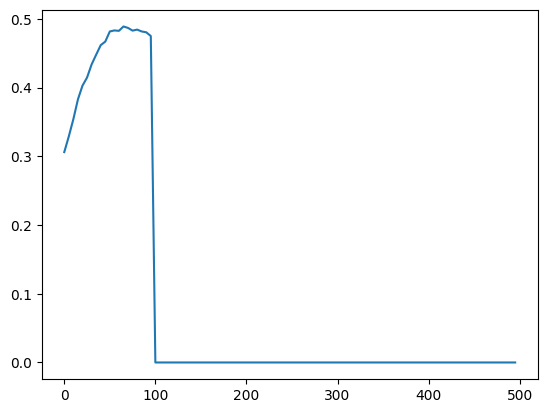

<Figure size 640x480 with 0 Axes>

In [ ]:
graph_data = np.zeros(num_epochs)

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    model.train()
    
    for batch in dataloader:
        sequences, labels = batch
        sequences, labels = sequences.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 计算统计量
        total_loss += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    # 计算epoch指标
    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    
    print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy on train: {epoch_acc:.4f}')
    if epoch %5 ==0:
        test_accuracy = evaluate_model(model, test_loader, device)
        graph_data[epoch//5] = test_accuracy


import matplotlib.pyplot as plt

plt.plot(np.arange(epoch//5) * 5, graph_data[:epoch//5])
plt.savefig('3filters' + '.png')
plt.show()


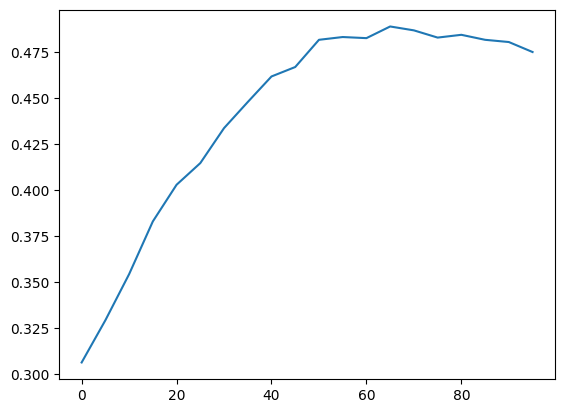

训练过程，调用方法
loss为交叉熵

optim.Adam(model.parameters(), lr=0.001)



In [84]:
# 8. 保存模型
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'max_sequence_length': max_sequence_length,
    'model_params': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'num_filters': num_filters,
        'filter_sizes': filter_sizes,
        'num_classes': num_classes
    }
}, 'text_cnn_model.pth')

In [85]:
# 2. 加载保存的模型和词汇表
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('text_cnn_model.pth', map_location=device)

# 重新实例化模型结构
model_params = checkpoint['model_params']
model = TextCNN(
    vocab_size=model_params['vocab_size'],
    embedding_dim=model_params['embedding_dim'],
    num_filters=model_params['num_filters'],
    filter_sizes=model_params['filter_sizes'],
    num_classes=model_params['num_classes']
).to(device)

# 加载模型权重
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # 设置为评估模式

# 获取词汇表和序列长度
vocab = checkpoint['vocab']
max_sequence_length = checkpoint['max_sequence_length']

C:\Users\16590\AppData\Local\Temp\ipykernel_11272\3157136224.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('text_cnn_model.pth', map_location=d

# 关于pth和chekpoint


测试数据和训练数据不同之处在于：
1.vocab不能受测试数据扩充